<a href="https://colab.research.google.com/github/TobiBu/graddays/blob/main/day_3/notebooks/HNN_tutorial_solar_system_single_planet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial on HNN for the solar system

This tutorial uses Hamiltonian NEural Networks to learn the dynamics of the solar system from real data from NASA.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import autograd
import autograd.numpy as np

import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

import csv

import requests
from datetime import datetime
from tqdm import tqdm


In [2]:
# @title some helper functions
# --------------------------------------------------------------------------------------------- #

def norm(x):
    # normalize input
    return  (x / abs(x).max())

# --------------------------------------------------------------------------------------------- #

def read_data(data):
    pos = []
    vel = []
    t = []

    run = False
    data = data.split("\n")
    for row in data:
        if row == "$$SOE":
            run=True
            continue
        if row == "$$EOE": run=False
        if run:
            data_row = row.split(",")
            pos.append(data_row[2:5])
            vel.append(data_row[5:8])
            t.append(datetime.strptime(data_row[1][6:-5], "%Y-%b-%d %H:%M:%S"))

    return np.asarray(pos).astype(float), np.asarray(vel).astype(float), np.asarray(t)

# --------------------------------------------------------------------------------------------- #

def prep_data(data, time):
    q = np.array([])
    dq = np.array([])
    p = np.array([])
    dp = np.array([])

    shape = [len(data[0][0])-1, 3*len(data)]

    for j in tqdm(range(len(data[0][0])-1)):
        for i in range(len(data)):

            q = np.append(q, data[i][0][j])
            p = np.append(p, data[i][1][j])

    q = q.reshape(shape)
    p = p.reshape(shape)

    max_q = []
    max_p = []
    max = abs(data).max(2).flatten()
    for i in range(len(data)):
        max_q.append(max[i*6 : 6*i+3])
        max_p.append(max[i*6+3 : 6*i+6])

    max_q = np.array(max_q).flatten()
    max_p = np.array(max_p).flatten()

    for j in range(len(q.T)):
        q.T[j] = q.T[j] / max_q[j]
        p.T[j] = p.T[j] / max_p[j]

    max_all = np.array([max_q, max_p]).flatten()

    """max_q = abs(q).max()
    max_p = abs(p).max()

    q = norm(q)
    p = norm(p)"""

    dq = np.diff(q, axis=0)
    dp = np.diff(p, axis=0)

    """for j in range(len(data)):
        dq.T[3*j:3*j+3] = 100 * dq.T[3*j:3*j+3] / np.diff(time[j])[0].days
        dp.T[3*j:3*j+3] = 100 * dp.T[3*j:3*j+3] / np.diff(time[j])[0].days"""

    return q[0:-1], dq, p[0:-1], dp, max_all   # remove last element to match diff

# --------------------------------------------------------------------------------------------- #

def HNN(x, model):
    H = model(x)

    # this is where the HNN magic happens!!
    x_field = torch.autograd.grad(H.sum(), x, create_graph=True, retain_graph=True)[0] # gradients for field
    dH = torch.zeros_like(x_field)

    # Hamiltonian equations
    objects = int(len(x_field.T)/2)
    for i in range( objects ):
        # dq = dH/dp
        dH.T[i] = x_field.T[i+objects]
        # dp = -dH/dq
        dH.T[i+objects] = -x_field.T[i]

    return dH

# --------------------------------------------------------------------------------------------- #

def integrate_model(model, t_span, y0, t_eval, baseline=True):

    def fun(t, np_x, model=model, baseline=baseline):
        #x = torch.tensor( np_x, requires_grad=True).view(1,2)
        x = torch.tensor( np_x, requires_grad=True)
        if baseline:
            pred = model(x)
        else:
            pred = HNN(x, model)

        return pred.detach().numpy()

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, t_eval=t_eval)

# --------------------------------------------------------------------------------------------- #

def reshape_data(data):
    targets = int(data.shape[0]/(3*2))
    steps = data.shape[1]

    data_out = np.zeros([targets, 2, steps, 3])

    for i in range(steps):
        for j in range(targets):
            data_out[j][0][i][0] = data[3*j][i]
            data_out[j][0][i][1] = data[3*j+1][i]
            data_out[j][0][i][2] = data[3*j+2][i]

            data_out[j][1][i][0] = data[3*targets+3*j][i]
            data_out[j][1][i][1] = data[3*targets+3*j+1][i]
            data_out[j][1][i][2] = data[3*targets+3*j+2][i]

    return data_out

# --------------------------------------------------------------------------------------------- #

def plot_phase_space(data, target_names, title):
    fig, axs = plt.subplots(len(target_names),3, figsize=(15,5*len(target_names)))
    coords = ["x", "y", "z"]
    c=np.linspace(0,1,len(data[0][0]))

    if len(target_names) == 1:
        for j in range(0, 3):
            axs[j].scatter(data[0][0].T[j], data[0][1].T[j], s=2, c=c)
            axs[j].set_title(target_names[0] + " " + coords[j])
    else:
        for i in range(len(target_names)):
            for j in range(0, 3):
                axs[i, j].scatter(data[i][0].T[j], data[i][1].T[j], s=2, c=c)
                axs[i, j].set_title(target_names[i] + " " + coords[j])

    fig.suptitle(title)
    plt.show()

# --------------------------------------------------------------------------------------------- #

def plot_space(data, target_names, title, color=False):
    fig = plt.figure()
    fig.set_figheight(12)
    fig.set_figwidth(12)

    ax = fig.add_subplot(projection='3d')

    if color:
        c=np.linspace(0,1,len(data[0][0]))
        for i in range(len(target_names)):
            ax.scatter(data[i][0].T[0], data[i][0].T[1], data[i][0].T[2], s=1, label=target_names[i], c=c)

    else:
        for i in range(len(target_names)):
            ax.scatter(data[i][0].T[0], data[i][0].T[1], data[i][0].T[2], s=1, label=target_names[i])


    #ax.view_init(elev=0, roll=0, azim=300)
    fig.suptitle(title)
    plt.legend()
    plt.show()

# --------------------------------------------------------------------------------------------- #

def plot_phase_space_HM(data, target_names, title, model):
    fig, axs = plt.subplots(len(target_names),3, figsize=(15,5*len(target_names)),subplot_kw=dict(projection='3d'))
    coords = ["x", "y", "z"]
    c=np.linspace(0,1,len(data[0][0]))


    if len(target_names) == 1:
        lim = max(abs(data.min()), data.max()) * 1.2

        x = np.linspace(-lim,lim,100)
        y = np.linspace(-lim,lim,100)

        X,Y = np.meshgrid(x,y)

        plot_H = torch.tensor(np.vstack([X.ravel(), X.ravel(),X.ravel(), Y.ravel(), Y.ravel(), Y.ravel()]).T, dtype=torch.double)
        H_pred = model(plot_H).detach().numpy()

        for j in range(0, 3):
            out_H = np.array(H_pred.T[j]+H_pred.T[j+3]).reshape(X.shape)

            axs[j].plot_surface(X, Y, out_H, rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
            #axs[j].scatter(HNN_data[0][0].T[j], HNN_data[0][1].T[j],  s=1, c=c)
            axs[j].set_xlabel('q')
            axs[j].set_ylabel('p')
            axs[j].set_zlabel('H')
            axs[j].legend()
            axs[j].set_title(target_names[0] + " " + coords[j])


    else:
        for i in range(len(target_names)):
            lim = max(abs(data[i].min()), data[i].max()) * 1.2

            x = np.linspace(-lim,lim,100)
            y = np.linspace(-lim,lim,100)

            X,Y = np.meshgrid(x,y)

            plot_H = torch.tensor(np.vstack([X.ravel(), X.ravel(),X.ravel(), Y.ravel(), Y.ravel(), Y.ravel()]).T, dtype=torch.double)
            H_pred = model(plot_H).detach().numpy()


            for j in range(0, 3):
                out = np.array(H_pred.T[j]+H_pred.T[j+3]).reshape(X.shape)
                axs[i, j].plot_surface(X, Y, out, rstride=1, cstride=1,
                        cmap='viridis', edgecolor='none')
                axs[i, j].set_xlabel('q')
                axs[i, j].set_ylabel('p')
                axs[i, j].set_zlabel('H')
                axs[i, j].legend()
                axs[i, j].set_title(target_names[i] + " " + coords[j])

    fig.suptitle(title)
    plt.show()

# --------------------------------------------------------------------------------------------- #


# API call

In [4]:
# https://ssd-api.jpl.nasa.gov/doc/horizons.html

url = "https://ssd.jpl.nasa.gov/api/horizons.api"
format = "format=text"
command = "COMMAND=" # target body
targets = ["10", "899"] #["10", "199", "299", "399", "301", "499", "599", "699", "799", "899"]  # sun, mercury, venus, earth, moon, mars, jupiter, saturn, uranus, neptun
target_names = ["sun", "neptun"] #["sun", "mercury", "venus", "earth", "moon", "mars", "jupiter", "saturn", "uranus", "neptun"]
obj_data = "OBJ_DATA='NO'"
ephemeris = "MAKE_EPHEM='YES'"
eph_type = "EPHEM_TYPE='VECTORS'"
vec_table = "VEC_TABLE='2'"
center = "CENTER='500@0'"
start = "START_TIME='1800-01-01'"
stop = "STOP_TIME='2023-01-01'"
step = "STEP_SIZE='1 y'"
cal_type = "CAL_TYPE=GREGORIAN"
vector_labels = "VEC_LABELS=NO"
csv_format = "CSV_FORMAT=YES"
units = "OUT_UNITS='AU-D'"
#quantities = "QUANTITIES='1,9,20,23,24,29'"

In [8]:
data = []
time = []
for target in targets:
    path = url+"?"+format+"&"+command+target+"&"+obj_data+"&"+ephemeris+"&"+eph_type+"&"+vec_table+"&"+center+"&"+start+"&"+stop+"&"+step+"&"+cal_type+"&"+vector_labels+"&"+csv_format+"&"+units
    q, p, t = read_data(requests.get(path).text)
    data.append([[q], [p]])
    time.append([t])

data = np.asarray(data).reshape((len(targets),2,len(data[0][0][0]),3))
time = np.asarray(time).reshape((len(targets),len(time[0][0])))

In [9]:
print(data.shape)

(2, 2, 224, 3)


## Data shape

10 x target body <br>
2 x vectors - q & p <br>
n x data points <br>
3 x coordinates - x, y, z

# Phase spaces for all bodies in the system

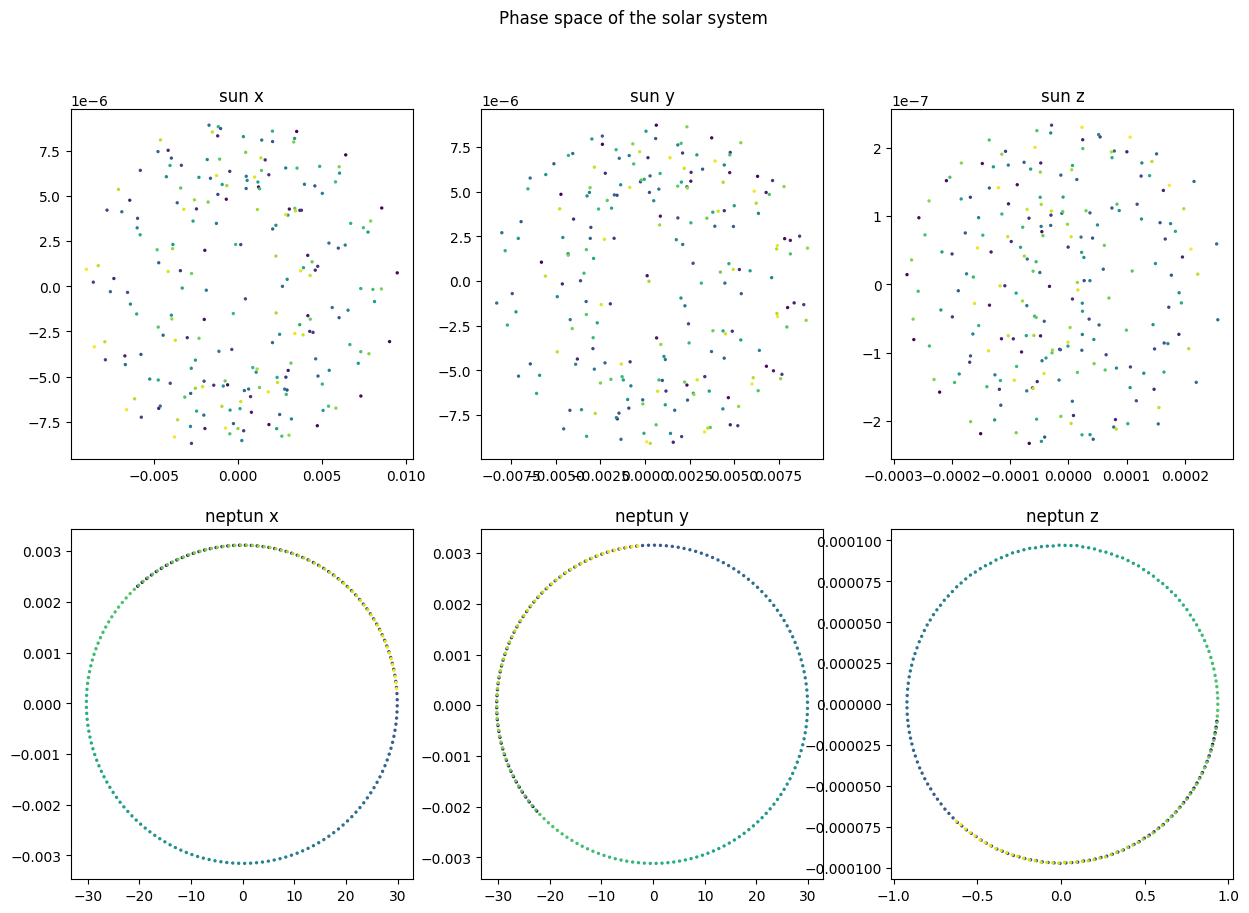

In [10]:
plot_phase_space(data, target_names, "Phase space of the solar system")

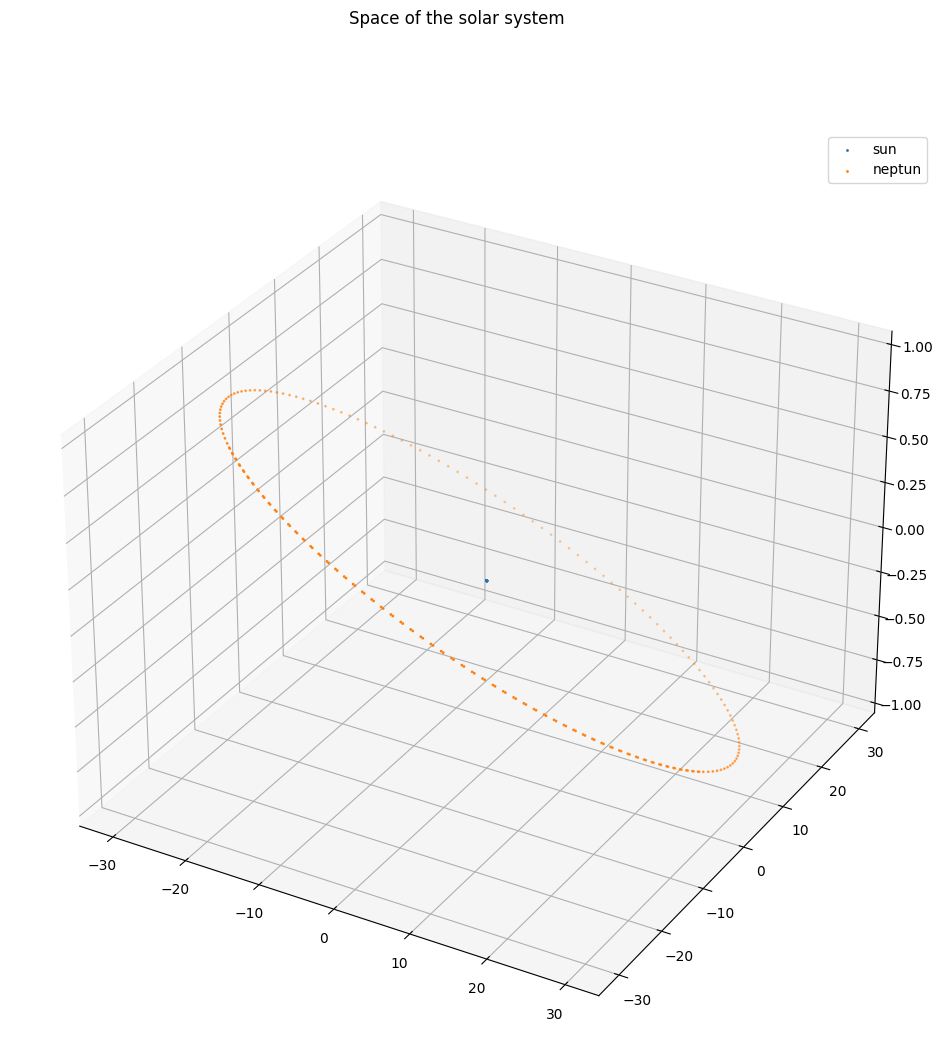

In [11]:
plot_space(data, target_names, "Space of the solar system")

# Learning the solar system

## Preparing the data

In [12]:
def norm(x):
    # normalize input
    #x = (x.T - x.min(1))
    return  (x.T / abs(x).max(1)).T

In [13]:
nep_x = norm(np.array([data[1][0].T[0], data[1][1].T[0]]))
nep_dx = np.diff(nep_x, axis=1)

nep_x = torch.tensor(nep_x.T[0:-1], dtype=torch.float32, requires_grad=True)
nep_dx = torch.tensor(nep_dx.T, dtype=torch.float32, requires_grad=True)

## Normal Neural Network

In [14]:
class MLP(nn.Module):
    def __init__(self, bodys) -> None:
        super().__init__()

        self.fc1 = nn.Linear(bodys, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, bodys)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

## Hamiltonian

## Training loop

In [15]:
def train(model, x, dx, batch_size=32, epochs=100, baseline=True, lr=1e-3):
    loss_hist = []
    ep_hist = []

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = nn.MSELoss()

    for step in tqdm(range(epochs)):
        model.train()

        batches = np.random.choice(len(x), len(x))

        for batch in range(0, len(x)//batch_size+1):

            low = batch * batch_size
            high = min((batch + 1) * batch_size, len(x))
            bb = batches[low:high]

            x_batch = x[bb]
            dx_batch = dx[bb]

            optimizer.zero_grad()

            if baseline:
                pred = model(x_batch)
            else:
                pred = HNN(x_batch, model)

            loss_val = loss(pred, dx_batch)
            loss_val.backward()
            optimizer.step()

        if step % (epochs/10) == 0:
            model.eval()
            if baseline:
                pred = model(x)
            else:
                pred = HNN(x, model)

            loss_val = loss(pred, dx)
            loss_hist.append(loss_val.item())
            ep_hist.append(step+1)

            #print(f"Epoch {step}/{epochs} --- Train-Loss: {loss_val.item()}")#{round(loss_val.item(), 3)}")

    plt.plot(ep_hist, loss_hist)

# Baseline NN

100%|██████████| 100/100 [00:01<00:00, 71.16it/s]


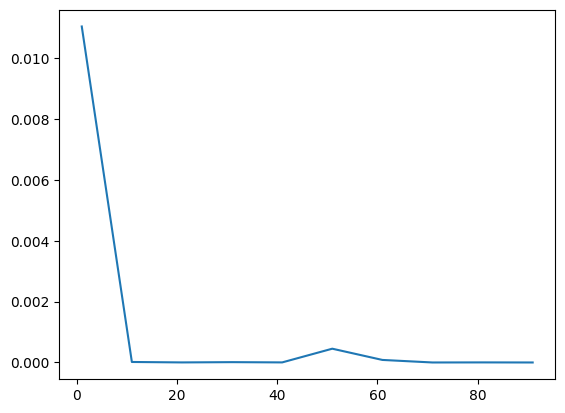

In [16]:
model_baseline = MLP(nep_x.shape[1])

train(model=model_baseline, x=nep_x, dx=nep_dx, batch_size=32, epochs=100, baseline=True, lr=1e-3)


# HNN

In [17]:
def HNN(x, model):
    H = model(x)

    # this is where the HNN magic happens!!
    x_field = torch.autograd.grad(H.sum(), x, create_graph=True, retain_graph=True)[0] # gradients for field
    dH = torch.zeros_like(x_field)

    # Hamiltonian equations
    # dq = dH/dp
    dH.T[0] = x_field.T[1]

    # dp = -dH/dq
    dH.T[1] = -x_field.T[0]

    return dH

100%|██████████| 100/100 [00:01<00:00, 55.80it/s]


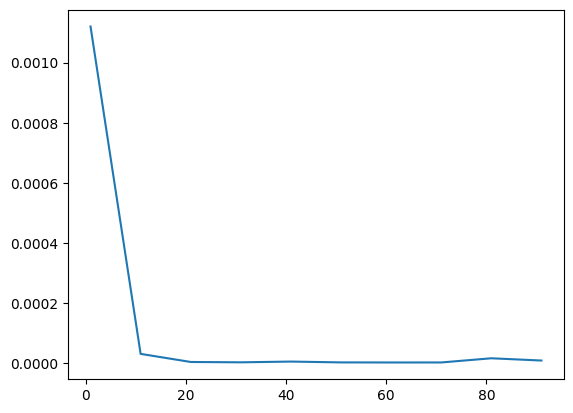

In [18]:
model_HNN = MLP(nep_x.shape[1])

train(model=model_HNN, x=nep_x, dx=nep_dx, batch_size=32, epochs=100, baseline=False, lr=1e-3)

# Predicting

In [19]:
def integrate_model(model, t_span, y0, t_eval, baseline=True):

    def fun(t, x, model=model, baseline=baseline):
        x = torch.tensor( x, requires_grad=True)

        if baseline:
            pred = model(x)
        else:
            pred = HNN(x, model)

        return pred.detach().numpy()

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, t_eval=t_eval)

In [20]:
q_p0 = nep_x[0].detach().numpy()
t_span = [0, 1000]
steps = 10000

# integrate
t = torch.linspace(t_span[0], t_span[1], steps)
xHNN = integrate_model(model_HNN.double(), t_span=t_span, y0=q_p0, t_eval=t, baseline=False)
xBaseline = integrate_model(model_baseline.double(), t_span=t_span, y0=q_p0, t_eval=t, baseline=True)

<ipython-input-17-d47f2684e477>:10: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  dH.T[0] = x_field.T[1]


In [21]:
HNN_data = reshape_data(xHNN.y)
Baseline_data = reshape_data(xBaseline.y)

# Plot the results
## phase space

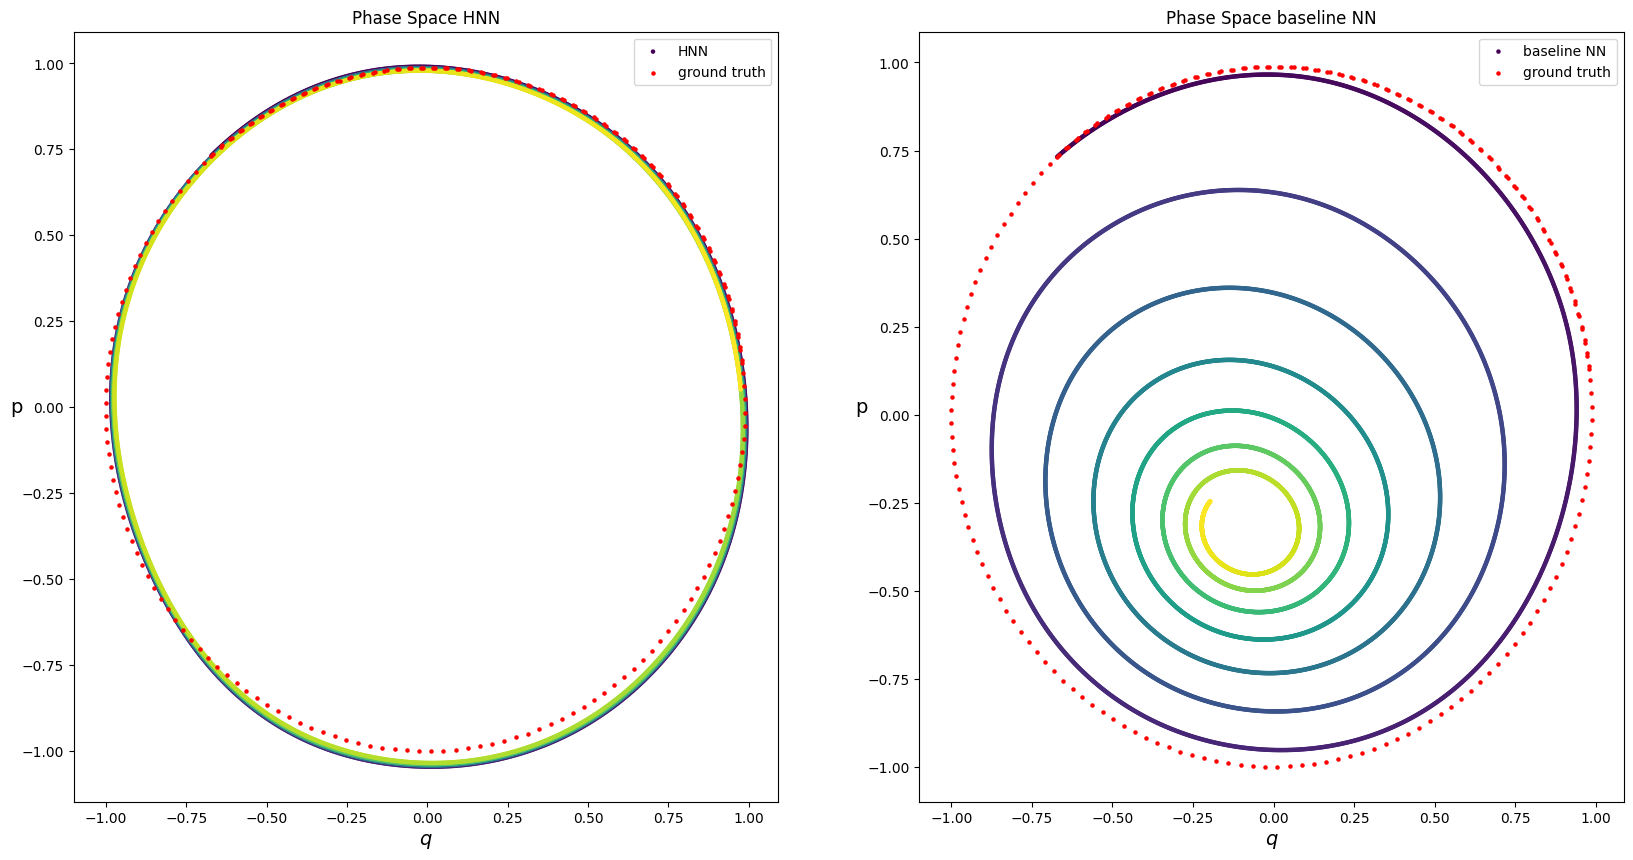

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))

# plot HNN
ax1.scatter(xHNN.y[0],xHNN.y[1], s=5, label='HNN', c=t)
ax1.scatter(nep_x.detach().numpy().T[0],nep_x.detach().numpy().T[1], s=5, label='ground truth', c="red")
ax1.set_xlabel("$q$", fontsize=14)
ax1.set_ylabel("p", rotation=0, fontsize=14)
ax1.set_title("Phase Space HNN")
ax1.legend()

# plot baseline NN
ax2.scatter(xBaseline.y[0],xBaseline.y[1], c=t, s=5, label='baseline NN')
ax2.scatter(nep_x.detach().numpy().T[0],nep_x.detach().numpy().T[1], s=5, label='ground truth', c="red")
ax2.set_xlabel("$q$", fontsize=14)
ax2.set_ylabel("p", rotation=0, fontsize=14)
ax2.set_title("Phase Space baseline NN")
ax2.legend()

plt.show()